**Insights from Failed Orders**

In this notebook, we'll analyze some order data from the Ground Transportation Manager platform, Gett. 

The full project description can be found here: 
- https://platform.stratascratch.com/data-projects/insights-failed-orders

We will investigate the following questions:
1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
4. Plot the distribution of average ETA by hours. How can this plot be explained?
5. BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
offers_df = pd.read_csv('datasets\data_offers.csv')
orders_df = pd.read_csv('datasets\data_orders.csv')

Doesn't look like offers_df contains any data relevant for the analysis - not quite sure what offer_id is.

In [87]:
offers_df.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [88]:
orders_df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [89]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [90]:
offers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [91]:
# combined_df = pd.merge(left=orders_df, right=offers_df, how='left', on='order_gk')
combined_df = orders_df
combined_df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [92]:
combined_df['order_status_key'].value_counts()

order_status_key
4    7307
9    3409
Name: count, dtype: int64

In [93]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


**Question 1**

Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

First, let's break down orders by driver assignment status.

Then, for each driver assignment status, we'll examine the breakdown of orders cancelled by client/system.

Relevant columns to look at:
- order_status_key - indicates whether order cancelled by client (4) or system (9)
- is_driver_assigned_key - indicates whether a driver has been assigned (0/1)
- cancellations_time_in_seconds - how many seconds passed before cancellation (by client!)

In [94]:
combined_df['is_driver_assigned_key'].value_counts(normalize=True)

is_driver_assigned_key
0    0.737402
1    0.262598
Name: proportion, dtype: float64

Out of all cancelled orders: 
- 74/26 split for orders cancelled before & after driver assignment, respectively

In [95]:
# breakdown by driver assignment status
cancelled_before = combined_df[combined_df['is_driver_assigned_key']==0]
cancelled_after = combined_df[combined_df['is_driver_assigned_key']==1]

# breakdown by cancellation status
cancelled_before_reasons = cancelled_before['order_status_key'].value_counts()
cancelled_after_reasons = cancelled_after['order_status_key'].value_counts()

cancelled_before_reasons_normalized = cancelled_before['order_status_key'].value_counts()*100/len(cancelled_before)
cancelled_after_reasons_normalized = cancelled_after['order_status_key'].value_counts()*100/len(cancelled_after)

In [96]:
cancelled_info_df = pd.DataFrame({'cancelled_before_cnt': cancelled_before_reasons, 
                                  'cancelled_after_cnt': cancelled_after_reasons, 
                                  'cancelled_before_normalized': cancelled_before_reasons_normalized, 
                                  'cancelled_after_normalized': cancelled_after_reasons_normalized},
                                  )
cancelled_info_df

,cancelled_before_cnt,cancelled_after_cnt,cancelled_before_normalized,cancelled_after_normalized
order_status_key,,,,
4,4496,2811,56.896988,99.89339
9,3406,3,43.103012,0.10661


Out of all cancelled orders: 
- 74/26 split for orders cancelled before & after driver assignment, respectively

Orders cancelled before driver assigned:
- 57/43 split for orders cancelled by client/system, respectively

Orders cancelled after driver assigned:
- Nearly 100% of orders cancelled by client

So, ~74% of cancelled orders were cancelled prior to driver assignment. Out of those orders, ~57% were cancelled by the client.

Additionally, nearly all orders that were cancelled by system occurred before driver assignment (3406 orders out of 3409). If an order was cancelled after a driver has been assigned, it was almost definitely cancelled by the client (2811 orders out of 2814).

https://seaborn.pydata.org/generated/seaborn.countplot.html

TO DO: Add text descriptions next to numeric legend & axis labels in countplot?

C:\Users\jimin\AppData\Local\Temp\ipykernel_66276\1231123000.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["4 (client cancelled)", "9 (system cancelled)"], fontsize=12)


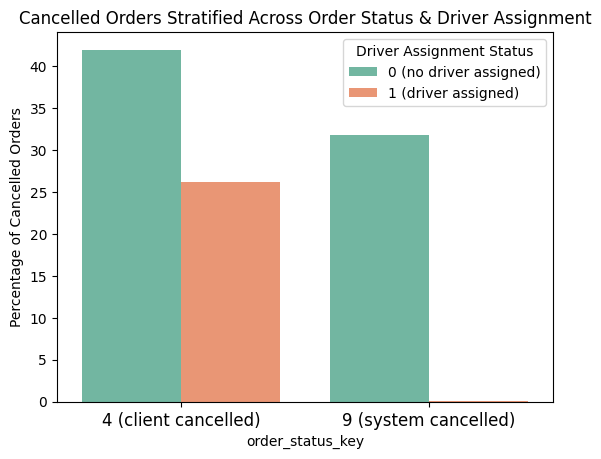

In [97]:
ax = sns.countplot(data=combined_df, x="order_status_key", hue="is_driver_assigned_key", palette="Set2", stat='percent')
plt.title("Cancelled Orders Stratified Across Order Status & Driver Assignment")
plt.xlabel("order_status_key")
plt.ylabel("Percentage of Cancelled Orders")
plt.legend(title="Driver Assignment Status")


# Annotate legend labels
handles, labels = ax.get_legend_handles_labels()
custom_labels = [
    "0 (no driver assigned)",
    "1 (driver assigned)",
]
ax.legend(handles, custom_labels, title="Driver Assignment Status")

# Annotate tick labels
ax.set_xticklabels(["4 (client cancelled)", "9 (system cancelled)"], fontsize=12)

plt.show()

**Question 2**

Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

Extract the hour from order_datetime.

In [98]:
time_info = combined_df['order_datetime'].str.split(":")

combined_df['hr'] = time_info.str[0]
combined_df['min'] = time_info.str[1]
combined_df['sec'] = time_info.str[2]

combined_df[['order_datetime', 'hr', 'min', 'sec']].head()

,order_datetime,hr,min,sec
0,18:08:07,18,08,07
1,20:57:32,20,57,32
2,12:07:50,12,07,50
3,13:50:20,13,50,20
4,21:24:45,21,24,45


Plot cancelled order count by hour.

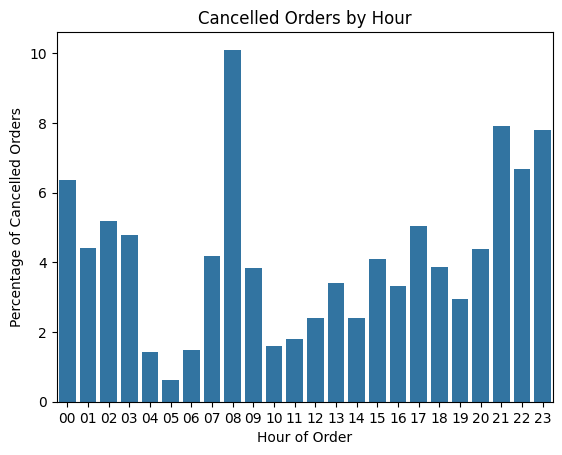

In [99]:
sns.countplot(data=combined_df, x="hr", order=sorted(combined_df["hr"].unique()), stat='percent')
plt.title("Cancelled Orders by Hour")
plt.xlabel("Hour of Order")
plt.ylabel("Percentage of Cancelled Orders")
plt.show()

In [104]:
top_5_cancellation_times = combined_df['hr'].value_counts(normalize=True)[:5]

print(top_5_cancellation_times)

hr
08    0.100971
21    0.078947
23    0.078014
22    0.066816
00    0.063736
Name: proportion, dtype: float64


Orders are most frequently cancelled at the following times:
- Early morning, around 8 am (~10%)
- Late at night, around 9 pm-midnight (~28%)

The most orders will be cancelled at hours of day when rides when rides are most frequently requested i.e. when drivers are likely to be busiest. The times mentioned above may be popular for requested rides for the following reasons: 
- 8 am is when many people may catch rides to go to work or catch flights
- 9 pm-midnight may be a popular time for requesting rides for people who don't want to drive late at night

**Question 3**

Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

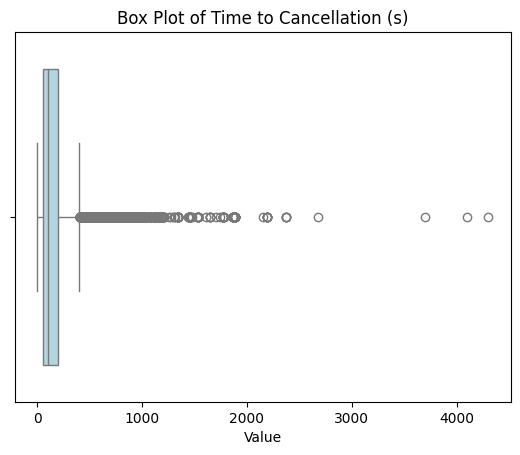

In [16]:
sns.boxplot(data=combined_df, x="cancellations_time_in_seconds", color="lightblue")
plt.title("Box Plot of Time to Cancellation (s)")
plt.xlabel("Value")
plt.show()


In [17]:
combined_df['cancellations_time_in_seconds'].describe()

count    23397.000000
mean       165.655084
std        203.553389
min          3.000000
25%         57.000000
50%        108.000000
75%        196.000000
max       4303.000000
Name: cancellations_time_in_seconds, dtype: float64

In [18]:
combined_df['cancellations_time_in_seconds'].quantile([0.9, 0.95, 0.99])

0.90    328.0
0.95    575.0
0.99    985.0
Name: cancellations_time_in_seconds, dtype: float64

99th percentile of cancellation time is about 800 seconds. However, from the boxplot we see many observations with rides over 1000 seconds, making the distribution appear more right skewed then it is.

Let's remove orders w/ cancellation time above 1000 seconds.

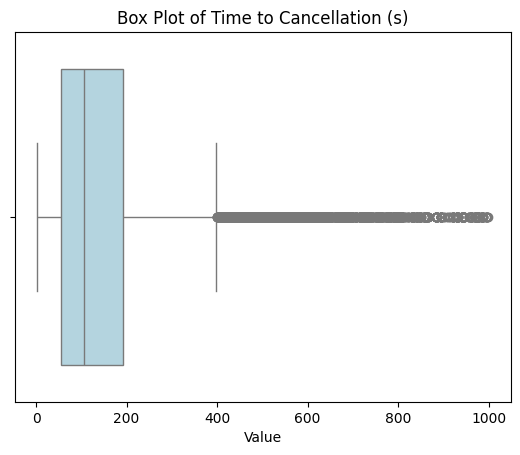

In [19]:
combined_df = combined_df[combined_df['cancellations_time_in_seconds']<1000]

sns.boxplot(data=combined_df, x="cancellations_time_in_seconds", color="lightblue")
plt.title("Box Plot of Time to Cancellation (s)")
plt.xlabel("Value")
plt.show()

Note that cancellations_time_in_seconds only records non-null cancellation times for orders cancelled by client.

All orders cancelled by the system have no cancellation time recorded. Based on this fact, it may be safe to assume that orders cancelled by the system are cancelled instantly.

In [ ]:
# cancellation times for orders cancelled by client & system, respectively
cancellation_times_client = combined_df[combined_df['order_status_key']==4]['cancellations_time_in_seconds']
cancellation_times_system = combined_df[combined_df['order_status_key']==9]['cancellations_time_in_seconds']
cancellation_times_system.value_counts(dropna=False, normalize=True)

Let's examine average time to cancellation stratified by hour of day and driver assignment status. 

In [20]:
avg_to_cancellation = combined_df.groupby(by=['hr', 'is_driver_assigned_key'])['cancellations_time_in_seconds'].mean().reset_index()

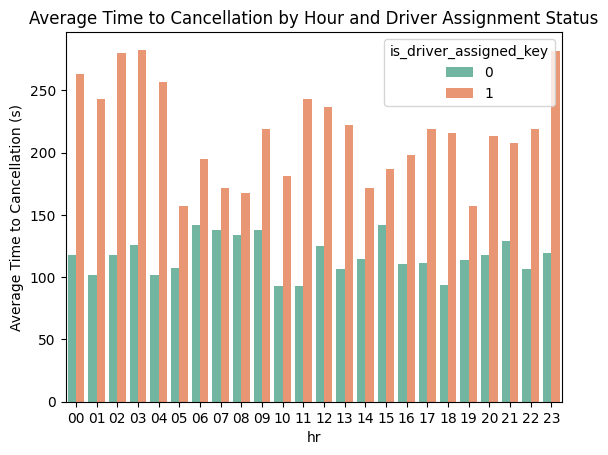

In [21]:
sns.barplot(data=avg_to_cancellation, x="hr", y="cancellations_time_in_seconds", hue="is_driver_assigned_key", palette="Set2")
plt.title("Average Time to Cancellation by Hour and Driver Assignment Status")
plt.ylabel("Average Time to Cancellation (s)")
plt.show()

Across all hours, the average time to cancellation is longer for orders where a driver was assigned compared to orders with no driver assigned. For a given hour, the difference in average cancellation time between driver assignment ranges from 150 seconds on the larger end to < 50 seconds on the lower end. 

This trend in longer average cancellation times for rides with driver assignment aligns with our findings above: 
- Recall: orders cancelled prior to driver assignment were more likely to be cancelled by the system (57% system, 43% client), whereas nearly all orders cancelled after driver assignment were cancelled by the client. 
- Let's assume that orders cancelled by the system are rejected instantly, whereas orders cancelled by the client may be cancelled hours after the initial order time. This is a reasonable assumption, as the system may cancel orders due to the lack of immediate availability, whereas clients may cancel orders due to unforseen events.
- Therefore, since nearly all orders cancelled after driver assignment were cancelled by clients, and clients typically take longer to cancel orders then the system, it should be expected that average time to cancellation is much higher for orders with driver assigned vs. without driver assignment, across all hours of the day.

4. Plot the distribution of average ETA by hours. How can this plot be explained?

In [22]:
avg_eta_by_hr = combined_df.groupby(['hr'])['m_order_eta'].agg('mean').reset_index()

avg_eta_by_hr

,hr,m_order_eta
0,00,375.781609
1,01,364.830000
2,02,381.560166
3,03,403.641304
4,04,286.690000
5,05,470.734694
6,06,493.256637
7,07,643.414587
8,08,676.529412
9,09,561.152305


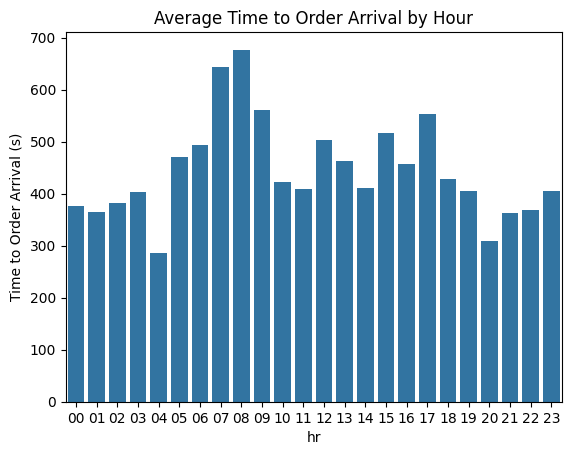

In [23]:
sns.barplot(data=avg_eta_by_hr, x="hr", y="m_order_eta")
plt.title("Average Time to Order Arrival by Hour")
plt.ylabel("Time to Order Arrival (s)")
plt.show()

In general, it seems like the average time to order arrival is longest around 7-8 am (~600-700 seconds) and 5 pm (~550 seconds).

This makes sense - most people travel to/from work around these times, so rides are most likely to be requested around these hours. Since drivers are likely busiest during these hours, the time to order arrival is likely to be longer as well.

5. BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [24]:
import h3
import folium 

print(h3.__version__)
print(folium.__version__)

4.1.2
0.19.2


In [25]:
def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [26]:
outer = [
    (37.804, -122.412),
    (37.778, -122.507),
    (37.733, -122.501)
]

poly = h3.LatLngPoly(outer)
print(poly)

<LatLngPoly: [3]>


In [27]:
d = poly.__geo_interface__
d

{'type': 'Polygon',
 'coordinates': (((-122.412, 37.804),
   (-122.507, 37.778),
   (-122.501, 37.733),
   (-122.412, 37.804)),)}

In [28]:
from IPython.core.display import display, HTML
from IPython.display import Image, display
from IPython.utils.text import columnize

print(columnize(dir(h3), displaywidth=100))

H3BaseException          __path__                     geo_to_h3shape               
H3CellInvalidError       __spec__                     get_base_cell_number         
H3DirEdgeInvalidError    __version__                  get_directed_edge_destination
H3DomainError            _cy                          get_directed_edge_origin     
H3DuplicateInputError    _h3shape                     get_icosahedron_faces        
H3FailedError            _version                     get_num_cells                
H3GridNavigationError    api                          get_pentagons                
H3LatLngDomainError      are_neighbor_cells           get_res0_cells               
H3MemoryAllocError       average_hexagon_area         get_resolution               
H3MemoryBoundsError      average_hexagon_edge_length  great_circle_distance        
H3MemoryError            cell_area                    grid_disk                    
H3NotNeighborsError      cell_to_boundary             grid_distance         

C:\Users\jimin\AppData\Local\Temp\ipykernel_66276\519746590.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [29]:
h3_address = h3.geo_to_h3shape(d) # lat, lng, hex resolution - {'type': 'Point', 'coordinates': (37.3615593, -122.0553238, 9)}
m = visualize_hexagons([h3_address])
display(m)

AttributeError: module 'h3' has no attribute 'h3_set_to_multi_polygon'